# **Pre Classification Analysis** 

In [1]:
import sys
sys.path
sys.path.append('c:\\Users\\3leso\\Documents\\Elena\\Uni\\MasterThesis\\MasterThesis_final\\code\\preprocessing')

### Set file paths

In [2]:
file_comments = "../../../../data/reddit/Ask_Politics_comments.zst"
file_submissions = "../../../../data/reddit/Ask_Politics_submissions.zst"

subreddit_here = "Ask_Politics"
subreddit = "Ask_Politics"


output_path = f"output/{subreddit_here}_new_preprocessing_com_rep.csv"



In [3]:
import pandas as pd
import numpy as np
import networkx as nx
import json
import matplotlib.pyplot as plt
import seaborn as sns
import community as community_louvain

import zstandard
import io

from sklearn.model_selection import train_test_split
from scipy import sparse
import random
from itertools import combinations
import collections
import multiprocessing
import copy
import time
import gurobipy
from gurobipy import *

pd.options.mode.chained_assignment = None

In [4]:
from preprocessing_functions import import_subreddit
from preprocessing_functions import filter_subreddit
from preprocessing_functions import aggregate_interactions_directed
from preprocessing_functions import get_counts_and_shares
from preprocessing_functions import find_max
from preprocessing_functions import build_undirected
from preprocessing_functions import get_submissions
from preprocessing_functions import get_comments_and_replies
from preprocessing_functions import assign_types
from preprocessing_functions import find_relevant_submissions
from preprocessing_functions import match_reply_comment_submission
from preprocessing_functions import preprocess_texts
from preprocessing_functions import import_merge_predicted_labels

***

## **Data Import**

In [5]:
# import data
data_comments = import_subreddit(file_comments)
data_submissions = import_subreddit(file_submissions)


In [6]:
# make df
df_comments = pd.DataFrame(data_comments)
df_submissions = pd.DataFrame(data_submissions)

In [7]:
# submissions
# filter relevant columns

submissions = get_submissions(df_submissions)

In [8]:
submissions['selftext'].value_counts()

selftext
[removed]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     15436
[deleted]                                                                                                                                                                                                                                                                                                                                  

In [9]:
# comments
# select relevant columns only

df_comments_replies = get_comments_and_replies(df_comments)

In [10]:
# assign types and extract them to separate dfs
comments, replies = assign_types(df_comments_replies, submissions)

## Plot

* no preprocessing added to tokens so far


1
1842
word_count
1       66629
150     18577
13       6655
15       6625
12       6622
        ...  
1524        1
1414        1
1389        1
1409        1
1369        1
Name: count, Length: 1382, dtype: int64


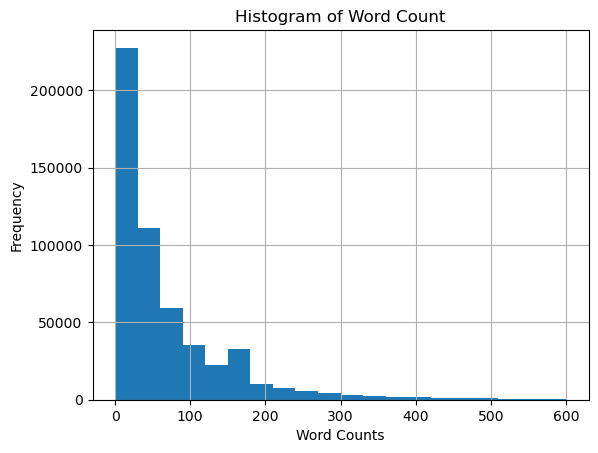

In [11]:
df_comments_replies["tokens"] = df_comments_replies["body"].apply(lambda x: x.split())
df_comments_replies["word_count"] = df_comments_replies["tokens"].apply(len)

print(df_comments_replies['word_count'].min())
print(df_comments_replies['word_count'].max())
print(df_comments_replies['word_count'].value_counts())

fig, ax = plt.subplots()
ax.hist(df_comments_replies['word_count'], bins = 20, range = (0, 600))
ax.set_title("Histogram of Word Count")
#ax.set_xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]) 
#ax.set_xticklabels(["0.0", "0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9", "1"])  
ax.set_xlabel("Word Counts")
ax.set_ylabel("Frequency")
ax.grid(True)

### Filter relevant submissions

* relevant = above subreddit-average number of comments
* relevant_comments: those with a parent, that is in relevant_submissions

In [12]:
# select relevant submissions (by avg. number of comments)

relevant_submissions, relevant_comments = find_relevant_submissions(df_comments = comments, df_submissions = submissions, submission_id_col = "parent_id", comment_id_col = "id")


print(f"Number of relevant submissions: {len(relevant_submissions)}")
print("Lost submissions: ", len(submissions) - len(relevant_submissions))

relevant_submissions

relevant_comments.reset_index(drop=True, inplace=True)
relevant_comments

4.448746648298934
Number of relevant submissions: 9979
Lost submissions:  37197


,author,created_utc,parent_id,subreddit_id,body,link_id,name,id,ups,score,downs,subreddit,likes,replies,stickied,send_replies,comment_type,date,type
0,TehNoff,1.355170e+09,14m26x,2t160,So what was wrong with /r/PoliticalDiscussion ...,14m26x,c7edr13,c7edr13,5.0,5,0.0,Ask_Politics,NaN,NaN,NaN,NaN,NaN,2012-12-10,comment
1,IBiteYou,1.355171e+09,14m26x,2t160,&gt;We will be adhering to the AskScience styl...,14m26x,c7ee45j,c7ee45j,3.0,3,0.0,Ask_Politics,NaN,NaN,NaN,NaN,NaN,2012-12-10,comment
2,[deleted],1.355171e+09,14m18a,2t160,[deleted],14m18a,c7eecqr,c7eecqr,1.0,1,0.0,Ask_Politics,NaN,NaN,NaN,NaN,NaN,2012-12-10,comment
3,Miss_anthropyy,1.355173e+09,14mg1m,2t160,I was at a conference in November where a grad...,14mg1m,c7eevhv,c7eevhv,7.0,7,0.0,Ask_Politics,NaN,NaN,NaN,NaN,NaN,2012-12-10,comment
4,hygo,1.355176e+09,14m18a,2t160,Stealing the /r/AskHistorians rules might beco...,14m18a,c7efwy3,c7efwy3,4.0,4,0.0,Ask_Politics,NaN,NaN,NaN,NaN,NaN,2012-12-10,comment
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92998,Much_Cellist8763,1.703372e+09,mh702s,2t160,As soon as we were taken off the gold standard...,mh702s,keo5f9w,keo5f9w,1.0,1,0.0,Ask_Politics,NaN,,False,True,NaN,2023-12-23,comment
92999,Extension_Buy_3734,1.703435e+09,xownab,2t160,Except for provider (doctors) who deal in cash...,xownab,ker63l6,ker63l6,1.0,1,0.0,Ask_Politics,NaN,,False,True,NaN,2023-12-24,comment
93000,nearmyst,1.703623e+09,14l0zf4,2t160,Biden was the worst candidate on the democrati...,14l0zf4,kf13how,kf13how,1.0,1,0.0,Ask_Politics,NaN,,False,True,NaN,2023-12-26,comment
93001,[deleted],1.703741e+09,167034x,2t160,[removed],167034x,kf8a3gp,kf8a3gp,1.0,1,0.0,Ask_Politics,NaN,,False,True,NaN,2023-12-28,comment


### Build df
* Match first level replies to relevant comments to relevant submissions
* Join = 'inner', because only keep replies, that have a parent in the relevant_comments
    * Missings due to replies, that did not find a comment to belong to.
    * This happend, because comments were dropped, if they were a comment to a submission, that had too little comments (below average)
    * Between comments and submissions, there won't be missings, as relevant_submissions were used to filter relevant_comments 

In [13]:
df_left = match_reply_comment_submission(replies, relevant_comments, relevant_submissions, 'left')
df_inner = match_reply_comment_submission(replies, relevant_comments, relevant_submissions, 'inner') # correct join

print("Left Join:", len(df_left))
print("Inner Join: ", len(df_inner))

print("Length of children in left, that are in inner as well: ", len(df_left[~df_left['msg_id_child'].isin(df_inner['msg_id_child'])]))
print("Difference: ", len(df_left) - len(df_inner))

Left Join: 91763
Inner Join:  53901
Length of children in left, that are in inner as well:  37862
Difference:  37862


In [14]:
df_matched = match_reply_comment_submission(replies, relevant_comments, relevant_submissions, 'inner')
df_matched

,msg_id_parent,msg_id_child,body_child,subreddit,exact_time_child,author_child,ups_child,score_child,downs_child,submission_id,...,author_parent,ups_parent,score_parent,downs_parent,exact_time_parent,submission_text,author_submission,ups_submission,score_submission,exact_time_submission
0,c7edr13,c7edsp8,"/r/Politicaldiscussion is too broad, and the c...",Ask_Politics,1.355170e+09,karmanaut,5.0,5,0.0,14m26x,...,TehNoff,5.0,5,0.0,1.355170e+09,"This subreddit is just starting out, so all of...",karmanaut,9.0,9,1.355160e+09
1,c7ee45j,c7ee4yl,The mods of AskScience are incredible strict i...,Ask_Politics,1.355171e+09,TehNoff,3.0,3,0.0,14m26x,...,IBiteYou,3.0,3,0.0,1.355171e+09,"This subreddit is just starting out, so all of...",karmanaut,9.0,9,1.355160e+09
2,c7ee45j,c7ee63a,It's probably best explained [in the rule post...,Ask_Politics,1.355171e+09,karmanaut,1.0,1,0.0,14m26x,...,IBiteYou,3.0,3,0.0,1.355171e+09,"This subreddit is just starting out, so all of...",karmanaut,9.0,9,1.355160e+09
3,c7eevhv,c7eewtr,"As I've heard it described before, ""Bipartisan...",Ask_Politics,1.355173e+09,cyco,5.0,5,0.0,14mg1m,...,Miss_anthropyy,7.0,7,0.0,1.355173e+09,"Tried to phrase this as neutrally as possible,...",karmanaut,2.0,2,1.355172e+09
4,c7efwy3,c7efxgv,"Hey, they're good rules. No sense starting fro...",Ask_Politics,1.355176e+09,karmanaut,1.0,1,0.0,14m18a,...,hygo,4.0,4,0.0,1.355176e+09,I. Submissions\n\nEvery submission in /r/ask_p...,karmanaut,5.0,5,1.355160e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53896,esnrw5z,kcyitc6,Me too.,Ask_Politics,1.702334e+09,Header1967,1.0,1,0.0,c8e98b,...,subsidiarity,NaN,1,NaN,1.562147e+09,\n\nI like having a decent political conversat...,chillermane,NaN,23,1.562098e+09
53897,jqjjy5q,kd3bh9v,"Sounds reasonable, great write-up, kudos to you!",Ask_Politics,1.702416e+09,FaviusArthum,1.0,1,0.0,14ot71b,...,dmntproductions,3.0,3,0.0,1.688412e+09,I was listening to a talk about authoritarian ...,AllTooHuman65,18.0,18,1.688317e+09
53898,eh3fmh4,kd4b3a5,"I'm not a fan of Shaprio, but all of your poin...",Ask_Politics,1.702431e+09,Wicked001,1.0,1,0.0,attjcv,...,erissays,NaN,18,NaN,1.550918e+09,Many people talk about how Shapiro would not s...,Marisa_Nya,NaN,0,1.550913e+09
53899,jl96sn2,kd5a9km,Big-brained user.,Ask_Politics,1.702447e+09,ClementAcrimony,1.0,1,0.0,pqykv0,...,timothycrawford369,1.0,1,0.0,1.684819e+09,After researching it seems like White Southern...,shivlad02,NaN,51,1.632014e+09


In [15]:
duplicated = df_matched[['body_child', "body_parent", 'subreddit', "msg_id_child", "msg_id_parent", "author_parent", "author_child"]]
duplicated = duplicated[duplicated.duplicated(['body_child', "body_parent", "author_parent", "author_child"], keep=False) == True]
duplicated

,body_child,body_parent,subreddit,msg_id_child,msg_id_parent,author_parent,author_child


### Filter for Subreddit

In [16]:
# filter for specific subreddit --> technically unnecessary
# also converts date-time and label column

df = filter_subreddit(df_matched, subreddit)


### Select High Quality Texts


* Filtering
    * remove deleted or removed parent and child texts (submissions no problem)
    * remove deleted authors of parents and childs (submissions no problem)
    * remove bodies (parents and childs) whose exact text occurred too often within the subreddit (i.e. bots)
    

* Preprocessing of texts
    * remove user mentions
    * remove subreddit mentions
    * remove URLs
    * remove line breaks
    * remove multiple spaces
    * replace &amp with and
    * (remove brackets and exclamation marks --> better not, they contain context)


* Filtering, second step
    * remove too short replies & comments (submissions no problem)


In [17]:
df['body_child'].value_counts().head(10)

df['body_parent'].value_counts().head(5)

#df[df['body_child'] == "Sorry, your post has been removed because your account does not currently meet the minimum required karma to post in this subreddit.\n\n\n*
# I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/AmericanPolitics) if you have any questions or concerns.*"]

# don't filter based on frequency of a text
# short replies (like thank you), will be removed with len < 5
# frequent comments can just be active comments
# bots are removed by author = [removed]


body_parent
[removed]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [18]:
df = preprocess_texts(data = df, length = 5)
df

Length 5 removes 2273 interactions


,msg_id_parent,msg_id_child,body_child,subreddit,exact_time_child,author_child,ups_child,score_child,downs_child,submission_id,...,author_parent,ups_parent,score_parent,downs_parent,exact_time_parent,submission_text,author_submission,ups_submission,score_submission,exact_time_submission
0,c7edr13,c7edsp8,"is too broad, and the comments there are unli...",Ask_Politics,2012-12-10 20:02:32,karmanaut,5.0,5,0.0,14m26x,...,TehNoff,5.0,5,0.0,2012-12-10 20:00:08,"This subreddit is just starting out, so all of...",karmanaut,9.0,9,2012-12-10 17:28:11
1,c7ee45j,c7ee4yl,The mods of AskScience are incredible strict i...,Ask_Politics,2012-12-10 20:19:44,TehNoff,3.0,3,0.0,14m26x,...,IBiteYou,3.0,3,0.0,2012-12-10 20:18:35,"This subreddit is just starting out, so all of...",karmanaut,9.0,9,2012-12-10 17:28:11
2,c7ee45j,c7ee63a,It's probably best explained in the rule post ...,Ask_Politics,2012-12-10 20:21:20,karmanaut,1.0,1,0.0,14m26x,...,IBiteYou,3.0,3,0.0,2012-12-10 20:18:35,"This subreddit is just starting out, so all of...",karmanaut,9.0,9,2012-12-10 17:28:11
3,c7eevhv,c7eewtr,"As I've heard it described before, Bipartisans...",Ask_Politics,2012-12-10 20:58:58,cyco,5.0,5,0.0,14mg1m,...,Miss_anthropyy,7.0,7,0.0,2012-12-10 20:57:07,"Tried to phrase this as neutrally as possible,...",karmanaut,2.0,2,2012-12-10 20:44:55
4,c7efwy3,c7efxgv,"Hey, they're good rules. No sense starting fro...",Ask_Politics,2012-12-10 21:49:58,karmanaut,1.0,1,0.0,14m18a,...,hygo,4.0,4,0.0,2012-12-10 21:49:13,I. Submissions Every submission in must be A...,karmanaut,5.0,5,2012-12-10 17:13:34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42002,eildsfz,kcank7h,That's not apples-to-apples. A better comparis...,Ask_Politics,2023-12-06 23:27:36,CoyoteKyle15,2.0,2,0.0,b1fvxd,...,maracay1999,NaN,29,NaN,2019-03-15 15:27:00,"Stalin killed way more people than Hitler, but...",Alpha_Narwhal,NaN,0,2019-03-15 14:53:46
42003,ffre1be,kcpthf9,Don't Walk Run Productions is highly disingenu...,Ask_Politics,2023-12-10 02:15:10,The_Grizzly-,1.0,1,0.0,eufkoe,...,Jabbam,NaN,1,NaN,2020-01-27 20:16:08,I follow a lot of lefties and I wanna balance ...,FezAndWand,NaN,2,2020-01-27 00:07:50
42004,jqjjy5q,kd3bh9v,"Sounds reasonable, great write-up, kudos to you!",Ask_Politics,2023-12-12 21:26:06,FaviusArthum,1.0,1,0.0,14ot71b,...,dmntproductions,3.0,3,0.0,2023-07-03 19:25:18,I was listening to a talk about authoritarian ...,AllTooHuman65,18.0,18,2023-07-02 16:57:59
42005,eh3fmh4,kd4b3a5,"I'm not a fan of Shaprio, but all of your poin...",Ask_Politics,2023-12-13 01:23:46,Wicked001,1.0,1,0.0,attjcv,...,erissays,NaN,18,NaN,2019-02-23 10:27:54,Many people talk about how Shapiro would not s...,Marisa_Nya,NaN,0,2019-02-23 09:06:28


In [19]:
#df

duplicated = df[['body_child', "body_parent", 'subreddit', "msg_id_child", "msg_id_parent", "author_parent", "author_child"]]
duplicated = duplicated[duplicated.duplicated(['body_child', "body_parent", "author_parent", "author_child"], keep=False) == True]
duplicated


,body_child,body_parent,subreddit,msg_id_child,msg_id_parent,author_parent,author_child


### Save and export

In [20]:
df.to_csv(output_path, index = False)
df = pd.read_csv(output_path)
df

,msg_id_parent,msg_id_child,body_child,subreddit,exact_time_child,author_child,ups_child,score_child,downs_child,submission_id,...,author_parent,ups_parent,score_parent,downs_parent,exact_time_parent,submission_text,author_submission,ups_submission,score_submission,exact_time_submission
0,c7edr13,c7edsp8,"is too broad, and the comments there are unli...",Ask_Politics,2012-12-10 20:02:32,karmanaut,5.0,5,0.0,14m26x,...,TehNoff,5.0,5,0.0,2012-12-10 20:00:08,"This subreddit is just starting out, so all of...",karmanaut,9.0,9,2012-12-10 17:28:11
1,c7ee45j,c7ee4yl,The mods of AskScience are incredible strict i...,Ask_Politics,2012-12-10 20:19:44,TehNoff,3.0,3,0.0,14m26x,...,IBiteYou,3.0,3,0.0,2012-12-10 20:18:35,"This subreddit is just starting out, so all of...",karmanaut,9.0,9,2012-12-10 17:28:11
2,c7ee45j,c7ee63a,It's probably best explained in the rule post ...,Ask_Politics,2012-12-10 20:21:20,karmanaut,1.0,1,0.0,14m26x,...,IBiteYou,3.0,3,0.0,2012-12-10 20:18:35,"This subreddit is just starting out, so all of...",karmanaut,9.0,9,2012-12-10 17:28:11
3,c7eevhv,c7eewtr,"As I've heard it described before, Bipartisans...",Ask_Politics,2012-12-10 20:58:58,cyco,5.0,5,0.0,14mg1m,...,Miss_anthropyy,7.0,7,0.0,2012-12-10 20:57:07,"Tried to phrase this as neutrally as possible,...",karmanaut,2.0,2,2012-12-10 20:44:55
4,c7efwy3,c7efxgv,"Hey, they're good rules. No sense starting fro...",Ask_Politics,2012-12-10 21:49:58,karmanaut,1.0,1,0.0,14m18a,...,hygo,4.0,4,0.0,2012-12-10 21:49:13,I. Submissions Every submission in must be A...,karmanaut,5.0,5,2012-12-10 17:13:34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42002,eildsfz,kcank7h,That's not apples-to-apples. A better comparis...,Ask_Politics,2023-12-06 23:27:36,CoyoteKyle15,2.0,2,0.0,b1fvxd,...,maracay1999,NaN,29,NaN,2019-03-15 15:27:00,"Stalin killed way more people than Hitler, but...",Alpha_Narwhal,NaN,0,2019-03-15 14:53:46
42003,ffre1be,kcpthf9,Don't Walk Run Productions is highly disingenu...,Ask_Politics,2023-12-10 02:15:10,The_Grizzly-,1.0,1,0.0,eufkoe,...,Jabbam,NaN,1,NaN,2020-01-27 20:16:08,I follow a lot of lefties and I wanna balance ...,FezAndWand,NaN,2,2020-01-27 00:07:50
42004,jqjjy5q,kd3bh9v,"Sounds reasonable, great write-up, kudos to you!",Ask_Politics,2023-12-12 21:26:06,FaviusArthum,1.0,1,0.0,14ot71b,...,dmntproductions,3.0,3,0.0,2023-07-03 19:25:18,I was listening to a talk about authoritarian ...,AllTooHuman65,18.0,18,2023-07-02 16:57:59
42005,eh3fmh4,kd4b3a5,"I'm not a fan of Shaprio, but all of your poin...",Ask_Politics,2023-12-13 01:23:46,Wicked001,1.0,1,0.0,attjcv,...,erissays,NaN,18,NaN,2019-02-23 10:27:54,Many people talk about how Shapiro would not s...,Marisa_Nya,NaN,0,2019-02-23 09:06:28


***
## **Descriptive Stats**

In [21]:
# get nr of users

comm_auth = list(df_comments['author'].unique())
sub_auth = list(df_submissions['author'].unique())

authors = comm_auth + sub_auth
print(len(authors))
authors = set(authors)
authors.remove('[deleted]')
print("Unique Users: ", len(set(authors)))

63102
Unique Users:  51209


### Time Stats and originally pulled counts

In [22]:
# Time frame
print("Time Frame \n---------------------------------------------")
print(f"Beginning of time frame: {df_comments_replies['date'].min()}")
print(f"End of time frame: {df_comments_replies['date'].max()}")
print("---------------------------------------------\n")

print("Number of Submissions, Comments and Replies \n---------------------------------------------")
print(f"Number of submissions: {len(submissions)}")
print(f"Number of comments and replies: {len(df_comments_replies)}")
print("---------------------------------------------\n")


# irrelevant, because submissions need to be filtered and matched to comments and replies

# print("Number of pure comments and first level replies \n---------------------------------------------")
# print(f"Number of comments: {len(comments)}")
# print(f"Number of replies: {len(replies)}")
# print(f"Sum of both: {len(comments) + len(replies)}")
# print("---------------------------------------------\n")

# print("Number of lost replies \n---------------------------------------------")
# print(f"Lost replies: {len(df_comments_replies) - (len(comments) + len(replies))}")
# print("---------------------------------------------\n")

Time Frame 
---------------------------------------------
Beginning of time frame: 2012-12-06
End of time frame: 2023-12-31
---------------------------------------------

Number of Submissions, Comments and Replies 
---------------------------------------------
Number of submissions: 47176
Number of comments and replies: 532593
---------------------------------------------



### Descriptive Stats after Matching

In [23]:
# Descriptive stats after matching

print("Number of unique replies: ", len(df_matched['msg_id_child'].unique()))
print("Number of unique comments: ", len(df_matched['msg_id_parent'].unique()))
print("Number of unique submissions: ", len(df_matched['submission_id'].unique()))

Number of unique replies:  53901
Number of unique comments:  33609
Number of unique submissions:  9299


### Descriptive Stats after cleaning for high quality texts

In [24]:
print("Unique Replies: ", len(df['msg_id_child'].unique()))
print("Unique Comments: ", len(df['msg_id_parent'].unique()))
print("Unique Submissions: ", len(df['submission_id'].unique()))

Unique Replies:  42007
Unique Comments:  27549
Unique Submissions:  8861


In [25]:
print("Unique Users: ", len(set(df['author_child']).union(df['author_parent'], df['author_submission'])))

Unique Users:  18942
